# Informes de mortalidad

Actualizado diariamente, este documento se [visualiza mejor aquí](https://nbviewer.jupyter.org/github/jaimevalero/COVID-19/blob/master/jupyter/Momo.ipynb).

Datos del Sistema de Monitorización de la Mortalidad diaria, que incluye las defunciones por todas las causas procedentes de 3.929 registros civiles informatizados, que representan el 92% de la población española.



In [1]:
# Cargamos datos
import Loading_data 
from matplotlib import pyplot as plt    
import warnings
warnings.filterwarnings('ignore')
import pandas as pd


In [2]:
df = pd.read_csv('https://momo.isciii.es/public/momo/data')
df.to_csv('/tmp/momo.csv')
df.head()

,ambito,cod_ambito,cod_ine_ambito,nombre_ambito,cod_sexo,nombre_sexo,cod_gedad,nombre_gedad,fecha_defuncion,defunciones_observadas,defunciones_observadas_lim_inf,defunciones_observadas_lim_sup,defunciones_esperadas,defunciones_esperadas_q01,defunciones_esperadas_q99
0,nacional,NaN,NaN,NaN,all,todos,all,todos,2018-07-03,1015,1015.0,1015.0,1038.50,902.45,1163.45
1,nacional,NaN,NaN,NaN,all,todos,all,todos,2018-07-04,981,981.0,981.0,1027.50,902.45,1183.00
2,nacional,NaN,NaN,NaN,all,todos,all,todos,2018-07-05,1022,1022.0,1022.0,1024.50,902.45,1211.20
3,nacional,NaN,NaN,NaN,all,todos,all,todos,2018-07-06,1034,1034.0,1034.0,1019.75,900.65,1212.30
4,nacional,NaN,NaN,NaN,all,todos,all,todos,2018-07-07,958,958.0,958.0,1019.75,900.65,1216.70


In [3]:
import janitor
import datetime



def pipeline_basic_with_query(df,query):
    ''' Basic filtering, using janitor
        Carga de datos, enriquecimiento de fechas y filtro por query configurable 
    '''
    LISTA_COLUMNAS_A_BORRAR = ['Unnamed: 0',
                           'defunciones_observadas_lim_inf',
                           'defunciones_observadas_lim_sup',
                           'defunciones_esperadas',
                           'defunciones_esperadas_q01',
                           'defunciones_esperadas_q99']
    return (
        df
        # Quitar: columnas
        .remove_columns(LISTA_COLUMNAS_A_BORRAR)
        .clean_names()
        # Enriquecer: fechas con columnas de años, mes y año-mes
        .rename_column( "fecha_defuncion", "date")
        .to_datetime('date')
        .join_apply(lambda x: x['date'].strftime('%Y')    , new_column_name="date_year"       )
        .join_apply(lambda x: x['date'].strftime('%m')    , new_column_name="date_month"      )
        .join_apply(lambda x: x['date'].strftime('%U')    , new_column_name="date_week"       )
        .join_apply(lambda x: x['date'].strftime('%Y-%m') , new_column_name="date_year_month" )
        .join_apply(lambda x: x['date'].strftime('%Y-%U') , new_column_name="date_year_week"  )
        # Filtrar:por query
        .filter_on( query )
        .set_index('date')
    )

def pipeline_basic(df):
    query = 'ambito       == "nacional" & nombre_gedad == "todos"  & nombre_sexo  == "todos"  '
    return pipeline_basic_with_query(df,query)




def extraer_defunciones_anuales_por_periodo(periodo_de_tiempo,query):
    '''Extrae el cuadro de comparativa por week, or year '''

    def pipeline_agregado_anual(periodo_de_tiempo,df,year):
        ''' Saca un dataframe de los datos agrupados por año'''
        return (
            df
            .filter_on('date_year == "'+year+'"'  )
            .groupby_agg( by='date_'+periodo_de_tiempo, agg='sum', agg_column_name="defunciones_observadas", new_column_name="agregados")
            .rename_column( "agregados", year)
            .join_apply(lambda x: x['date_'+periodo_de_tiempo]  , new_column_name=periodo_de_tiempo )
            .set_index('date_'+periodo_de_tiempo)
            [[periodo_de_tiempo,year]]
            .drop_duplicates()        
        )

    def pipeline_comparativa_anual(periodo_de_tiempo,df_2018,df_2019,df_2020):
        ''' Mergea tres dataframes de año, por periodo de tiempo'''
        return  (
        df_2018
        .merge( df_2019, on=periodo_de_tiempo, how='right')
        .merge( df_2020, on=periodo_de_tiempo, how='left')
        .sort_naturally(periodo_de_tiempo)
        .set_index(periodo_de_tiempo)
        .join_apply(lambda x: x['2020'] - x['2019'] , new_column_name="resta 2020 y 2019"  )
        )

    # Sacamos los datos y limpiamos
    df       = pd.read_csv('/tmp/momo.csv')
    df_basic = pipeline_basic_with_query(df,query)

    # Sacamos los datos agrupados por años
    muertes_2018  = pipeline_agregado_anual(periodo_de_tiempo,df=df_basic,year='2018')
    muertes_2019  = pipeline_agregado_anual(periodo_de_tiempo,df=df_basic,year='2019')
    muertes_2020  = pipeline_agregado_anual(periodo_de_tiempo,df=df_basic,year='2020')

    # Generamos un solo cuadro, con columna por año
    df_comparativa_años  = pipeline_comparativa_anual(periodo_de_tiempo,muertes_2018,muertes_2019,muertes_2020)
    return df_comparativa_años

def debug_extraer_defunciones_anuales_por_periodo():
    """ Solo para depurar"""
    query = 'ambito       == "nacional" & nombre_gedad == "todos"  & nombre_sexo  == "todos"  '
    df_muertes_anuales_por_semana = extraer_defunciones_anuales_por_periodo("week",query)
    df_muertes_anuales_por_mes    = extraer_defunciones_anuales_por_periodo("month",query)
    return  df_muertes_anuales_por_semana , df_muertes_anuales_por_mes


#df1, df2 = debug_extraer_defunciones_anuales_por_periodo()
#df1

## Sacamos el grafico comparativo de fallecimiento, para los años 2019 y 2020, por semana 

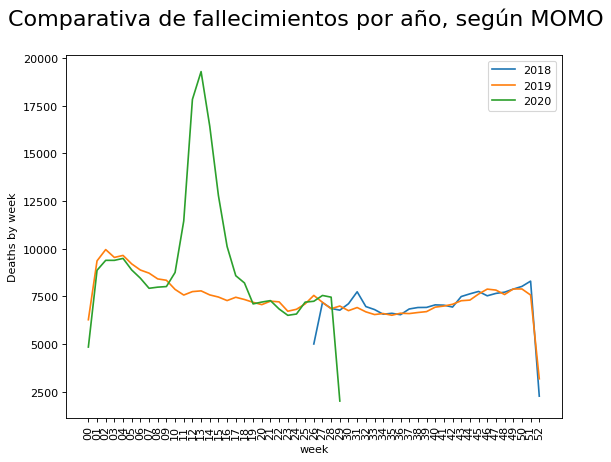

,2018,2019,2020,resta 2020 y 2019
month,,,,
01,nan,"42,034","40,697","-1,337"
02,nan,"35,571","34,584",-987
03,nan,"35,052","54,498","19,446"
04,nan,"32,273","56,419","24,146"
05,nan,"32,084","33,164","1,080"
06,nan,"29,915","29,188",-727
07,"28,660","31,454","21,272","-10,182"
08,"31,457","29,718",nan,nan
09,"28,824","28,229",nan,nan


In [4]:
from matplotlib import pyplot as plt    
from IPython.display import display, HTML
import pandas as pd

import numpy as np


periodo_de_tiempo="week"
query = 'ambito       == "nacional" & nombre_gedad == "todos"  & nombre_sexo  == "todos"  '

df = extraer_defunciones_anuales_por_periodo(periodo_de_tiempo,query) 

fig = plt.figure(figsize=(8, 6), dpi=80)
plt.xticks(rotation=90)

for ca in ['2018','2019','2020']:
    plt.plot(df[ca])
    plt.legend(df.columns)
    plt.xlabel(periodo_de_tiempo)
    plt.ylabel("Deaths by " + periodo_de_tiempo)
    fig.suptitle('Comparativa de fallecimientos por año, según MOMO', fontsize=20)
plt.show()



periodo_de_tiempo="month"
query = 'ambito       == "nacional" & nombre_gedad == "todos"  & nombre_sexo  == "todos"  '
df = extraer_defunciones_anuales_por_periodo(periodo_de_tiempo,query) 

df.style.format({"2020": "{:20,.0f}", 
                          "2018": "{:20,.0f}", 
                          "2019":  "{:20,.0f}", 
                          "resta 2020 y 2019": "{:20,.0f}", }).background_gradient(cmap='Wistia',subset=['resta 2020 y 2019'])



In [5]:
# Sacamos las muertes en madrid de hombres y de mujeres

import numpy as np 
import seaborn as sns


def pipeline_comparativa_semestral_diaria(df):
    return  (
        df
        .filter_on(" defunciones_observadas > 0")
        .remove_columns(['nombre_gedad','ambito','cod_ambito','cod_ine_ambito','nombre_ambito','cod_sexo','cod_gedad','date_year','date_week','date_month','date_year_week'])
        .rename_column( "nombre_sexo", "sexo")
        .rename_column( "date_year_month",  "mes")
        )

# Sacamos los datos de 2019
df          = pd.read_csv('/tmp/momo.csv')
query       = '  date_year == "2019" & nombre_ambito       == "Madrid, Comunidad de" & nombre_gedad == "todos"  & nombre_sexo  != "todos" &  date_month < "07" '
df_madrid_2019 =  pipeline_basic_with_query(df,query)
df_madrid_2019 =  pipeline_comparativa_semestral_diaria(df_madrid_2019)

# Sacamos los datos de 2020
df       = pd.read_csv('/tmp/momo.csv')
query = ' date_year == "2020"  &  nombre_ambito       == "Madrid, Comunidad de" & nombre_gedad == "todos"  & nombre_sexo  != "todos" &  date_month < "07" '
df_madrid_2020 =  pipeline_basic_with_query(df,query)
df_madrid_2020 =  pipeline_comparativa_semestral_diaria(df_madrid_2020)
   



df_madrid_2019

,sexo,defunciones_observadas,mes
date,,,
2019-01-01,hombres,60,2019-01
2019-01-02,hombres,55,2019-01
2019-01-03,hombres,63,2019-01
2019-01-04,hombres,62,2019-01
2019-01-05,hombres,55,2019-01
...,...,...,...
2019-06-26,mujeres,48,2019-06
2019-06-27,mujeres,48,2019-06
2019-06-28,mujeres,56,2019-06


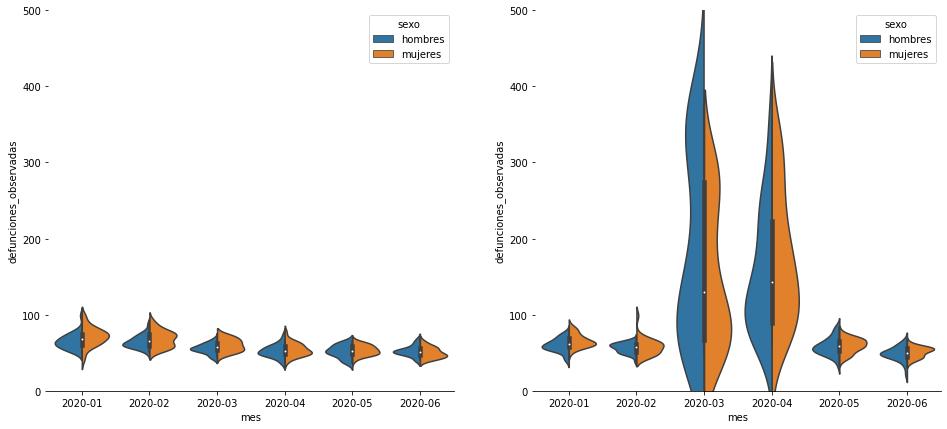

In [6]:

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

display(HTML("<h2>Distribucion muertes en Madrid  </h2>"))
display(HTML("<h3>Comparativa de defunciones, entre el primer semestre de 2019 y el del 2020</h3>"))

f, axes = plt.subplots(1 , 2 ,figsize=(16, 7), sharex=True)
sns.despine(left=True)

# Mismo limites, para poder comparar entre años
axes[0].set_ylim([0,500])
axes[1].set_ylim([0,500])


sns.violinplot(x="mes", y="defunciones_observadas", hue="sexo", 
                    data=df_madrid_2019,  split=True, scale="count", ax=axes[0] )


sns.violinplot(x="mes", y="defunciones_observadas", hue="sexo", 
                    data=df_madrid_2020,  split=True, scale="count", ax=axes[1])



In [7]:
# Aux functions
def print_categorical_variables(df):
    """ Get a dict with categorical variables"""    
    my_dict = {}
    cols = df.columns
    num_cols = df._get_numeric_data().columns
    # Show categorical values
    categorical = list(set(cols) - set(num_cols))
    for i in categorical : 
        if 'echa' not in i.lower() : my_dict[i] = df[i].unique()         
    return my_dict
df       = pd.read_csv('/tmp/momo.csv')
my_dict = print_categorical_variables(df)
my_dict

{'nombre_ambito': array([nan, 'Andalucía', 'Aragón', 'Asturias, Principado de',
        'Balears, Illes', 'Canarias', 'Cantabria', 'Castilla y León',
        'Castilla - La Mancha', 'Cataluña', 'Comunitat Valenciana',
        'Extremadura', 'Galicia', 'Madrid, Comunidad de',
        'Murcia, Región de', 'Navarra, Comunidad Foral de', 'País Vasco',
        'Rioja, La', 'Ceuta', 'Melilla'], dtype=object),
 'cod_gedad': array(['all', 'menos_65', '65_74', 'mas_74'], dtype=object),
 'cod_sexo': array(['all', '1', '6'], dtype=object),
 'ambito': array(['nacional', 'ccaa'], dtype=object),
 'nombre_sexo': array(['todos', 'hombres', 'mujeres'], dtype=object),
 'nombre_gedad': array(['todos', 'edad < 65', 'edad 65-74', 'edad > 75'], dtype=object),
 'cod_ambito': array([nan, 'AN', 'AR', 'AS', 'IB', 'CN', 'CB', 'CL', 'CM', 'CT', 'VC',
        'EX', 'GA', 'MD', 'MC', 'NC', 'PV', 'RI', 'CE', 'ML'], dtype=object)}